In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch.nn.functional import one_hot
import math
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.init as init


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [3]:
transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [4]:

batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:


class summary_layer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(summary_layer, self).__init__()

        self.beta_I = torch.eye(in_dim,in_dim).to(device)
        self.beta_func1 = nn.Linear(in_dim,out_dim).to(device)
        
    def forward(self, x):

        beta = self.beta_func1(self.beta_I)
        
        x1 = x@beta
        x2 = x@beta@(beta.T@beta)

        return x1,x2

    
class VGG(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features):
        super(VGG, self).__init__()

        self.features = features
        self.classifier = summary_layer(512,100)
        self.output = nn.Linear(100,10)

         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()

        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x1,x2 = self.classifier(x)
        return self.output(x1), self.output(x2)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
          512, 512, 512, 512, 'M'],
}


def vgg11():
    """VGG 11-layer model (configuration "A")"""
    return VGG(make_layers(cfg['A']))


def vgg11_bn():
    """VGG 11-layer model (configuration "A") with batch normalization"""
    return VGG(make_layers(cfg['A'], batch_norm=True))




In [6]:
import torch.optim as optim

net = vgg11()
net.to(device)

mseloss = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [7]:
import time

start = time.time()

results = []

for epoch in range(15):  # loop over the dataset multiple times
    count=0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        count=i
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs1, outputs2 = net(inputs)
        
        loss = criterion(outputs1, labels)+mseloss(outputs1, outputs2)+criterion(outputs2,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # print statistics

    print(f'[{epoch + 1}, {count + 1:5d}] loss: {running_loss  :.10f}')
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs1,outputs2 = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs1.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')   
    
    
    end = time.time()
    print(end - start)
    results += [[epoch,end-start,running_loss,100*correct/total]]
    running_loss = 0.0
print('Finished Training')

end = time.time()
print(end - start)

[1,  1563] loss: 7188.9376497269
Accuracy of the network on the 10000 test images: 18.34 %
26.60090470314026
[2,  1563] loss: 5418.0712361336
Accuracy of the network on the 10000 test images: 44.73 %
52.71683955192566
[3,  1563] loss: 3927.0816723108
Accuracy of the network on the 10000 test images: 61.13 %
78.96284604072571
[4,  1563] loss: 2969.4278850555
Accuracy of the network on the 10000 test images: 67.82 %
105.12736964225769
[5,  1563] loss: 2345.5257716775
Accuracy of the network on the 10000 test images: 71.05 %
130.96754717826843
[6,  1563] loss: 1862.6533141136
Accuracy of the network on the 10000 test images: 74.85 %
157.05671286582947
[7,  1563] loss: 1432.3578729033
Accuracy of the network on the 10000 test images: 74.66 %
183.0232675075531
[8,  1563] loss: 1052.5342521071
Accuracy of the network on the 10000 test images: 75.7 %
209.28954219818115
[9,  1563] loss: 738.1602619961
Accuracy of the network on the 10000 test images: 76.14 %
235.4650683403015
[10,  1563] loss:

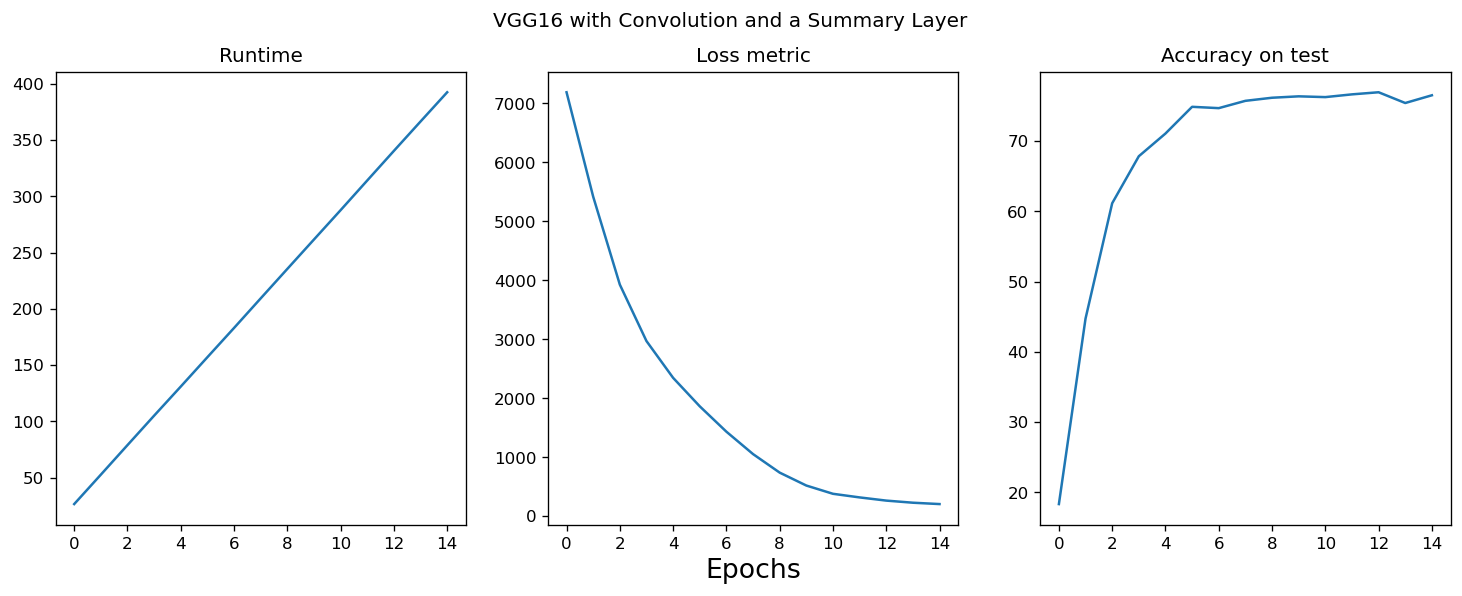

In [9]:
main_results = np.asarray(results)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5),dpi=120)
fig.suptitle('VGG16 with Convolution and a Summary Layer')
ax1.plot(main_results[:,0], main_results[:,1])
ax1.set_title("Runtime")
ax2.plot(main_results[:,0], main_results[:,2])
ax2.set_title("Loss metric")
ax2.set_xlabel('Epochs', fontsize=16)
ax3.plot(main_results[:,0], main_results[:,3])
ax3.set_title("Accuracy on test")

np.savetxt("../results_vgg16_summary.csv", main_results, delimiter=",")